# Beyond Confounders

- causal effect를 구할 떄, confounder를 control하는 것은 필수이다.
- 그렇다면 confounder가 아닌 변수들에 대해 control하는 것이 올바른 방법일까? 이들에 대해 3가지 시나리오를 알아보자.
  - Good
  - Harmful
  - Bad

## Good Control

- 먼저 control을 했을 때, 좋은 경우에 대해 알아보자.
- 연체자에게 메일을 보내는 것(treatment)이 돈을 돌려받는 것에 효과적인지 알고 싶다.
- 아래의 데이터는 random하게 뽑은 대상들이다.

In [4]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import graphviz as gr

In [2]:
data = pd.read_csv('../data/collections_email.csv')
data.head(3)

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479


In [6]:
model = sm.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


- email만을 control하면 계수가 음수가 나온다.
- 또한 p-value가 높게 나온다.
- 왜그럴까?
  - `payments`의 variability가 email이 아닌 다른 변수로 더 많이 설명가능하기 때문
- 그렇다면 더 좋은 값을 얻기 위해서는?
  - 다른 변수들을 이용해보자

In [7]:
model_1 = sm.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


- 다른 변수들을 추가하니 email이 긍정적인 효과가 있다고 한다.
- 또한 p-value도 낮아졌다
- 더 좋은 causal effect를 구했다고 할 수 있다.

- 그렇다면 `credit_limit`, `risk_score` 는 confounder라고 할 수 있을까?
- 아니다.
  - 일단 해당 데이터는 email 수신여부와 상관없이 random하게 뽑았기 때문에 RCT의 상황으로 이해할 수 있다.
  - 또한 아래에서처럼 `email`의 기존 variance과 `email`에 대해 위 두 변수를 fit한 residual의 variance가 거의 동일하다.

In [9]:
model_email = sm.ols('email ~ credit_limit + risk_score', data=data).fit()
email_resid = model_email.resid
print(f"Email original Var = {np.var(data['email'])}")
print(f"Email Residual Var = {np.var(email_resid)}")

Email original Var = 0.24991536
Email Residual Var = 0.24918421069820032


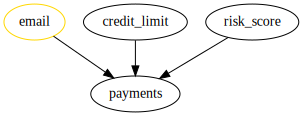

In [11]:
g = gr.Digraph()

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

- 이처럼 confounder가 아닌 변수에 대해서도 control을 했을 때, 좋은 경우를 살펴보았다.
- 그렇다면 반대로 안좋은 영향을 끼치는 경우에 대해 알아보자.

## Harmful Control

- 약의 효과가 병원에 머무는 시간에 대해 미치는 영향에 대해 알고 싶다고 해보자.
- 두 병원이 있는데
  - 병원 a는 많이 아픈 환자가 많아서 90%에게 약을 투약하고 10%는 플라시보를 투약했다.
  - 병원 b는 그렇지 않아서 90%에게 플라시보를, 10%에게 약을 투약했다고 한다.

In [13]:
data = pd.read_csv("../data/hospital_treatment.csv")
data.head(3)

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49


In [14]:
hosp_1 = sm.ols('days ~ treatment', data=data).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


- 위의 결과를 보면 약을 투약할수록 병원에 오래 남아있는 것으로 보인다.
- 하지만 약을 투약한 과정을 생각해보자 `severity`가 confounder라는 것을 파악할 수 있다.
  - `severity`가 심할수록 병원에 오래 남아있는 경우가 많고 ($E[Y_0 | T=0] < E[Y_0|T=1]$)
  - `severity`가 심할수록 약을 더 투약받았다. (random하게 투약한게 아니라) 

In [15]:
hosp_2 = sm.ols('days ~ treatment + severity', data=data).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


- 그래서 `severity`도 추가적으로 control해서 위와 같은 결과를 얻을 수 있다.
- 근데 그렇다면 `hosipital`은 어떻게 해야할까?
    - `hospital`은 `treatment`의 cause가 맞다.
    - 그런데 `severity`를 control했기에 outcome과는 관련이 없어졌다.
    - 그렇다면 control할 필요가 없어졌다. 하지만 control하면 위의 Good case처럼 variance를 줄일 수 있지 않을까?

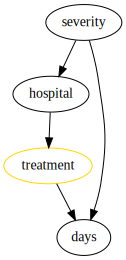

In [17]:
g = gr.Digraph()

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

In [16]:
hosp_3 = sm.ols('days ~ treatment + severity + hospital', data=data).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


- 예상과 다르게 ATE의 p-value는 더 커졌다
- 왜?
- 먼저 계수의 SE를 살펴보자. 2개의 변수로 회귀모델을 만들었다고 하면

$$V(\hat{\beta}) = \frac{1}{1-r_{12}^2}\frac{\sigma^2}{\sum (x_i - \bar{x})^2}$$

1. $r_{12}$는 두 변수의 표본상관계수이고 이 값이 1에 가까우면 SE가 커지게 된다. 
2. x변수의 var이 작아지면 SE가 커지게 된다.
- 따라서 treatment에 대해서만 좋은 predictor인 `hospital`을 control하면 오히려 SE가 커질 수 있는 것이다.
- 다중공선성을 생각해도 이해할 수 있을 것이다. (다중공선성의 영향중 하나)

- 따라서 confounder가 아니여도 outcome에 대해 좋은 predictor인 변수가 있다면 이를 모델에 넣어서 control하는 것은 좋은 결과를 낼 수 있을 것이다.
- 하지만 treatment에 대해서만 좋은 predictor라면 오히려 estimates의 variance를 증가시킬 수 있기에 추가하지 않는 것이 좋다.

## Bad Control - Selection Bias

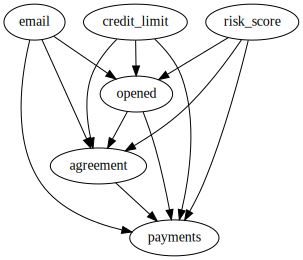

In [3]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

- 위의 그림에서 `opended`, `agreement` 는 `email`(treatment)에 의해 caused된다.
- 따라서 이 값들을 conditioning하면 selection bias가 발생한다.